In [1]:
import matplotlib.pyplot as plt
import numpy as np
from walras import ConstantProductAMM, LimitOrder
from functools import reduce
import math

Example usage

In [2]:
def plot_depth_chart(limit_orders, price_vector,A='A',B='B'):
    for order in limit_orders:
        assert order.A in (A,B)
        assert order.B in (A,B)
        assert order.A != order.B
    
    # Sort buy orders (buying B with A) and sell orders (selling B for A) based on price
    buy_orders = sorted([order for order in limit_orders if order.A == B], key=lambda x: x.price())
    sell_orders = sorted([order for order in limit_orders if order.A == A], key=lambda x: x.price())

    # Cumulative amounts for buy and sell orders
    cumulative_buy_amount = [0]
    buy_prices = []
    for order in buy_orders:
        amtB = order.poolB*order.price()
        price = 1./order.price()
        print('buy:', amtB, price)
        cumulative_buy_amount.append(cumulative_buy_amount[-1] + amtB)
        cumulative_buy_amount.append(cumulative_buy_amount[-1])
        buy_prices.append(price)
        buy_prices.append(price)
    cumulative_sell_amount = [0]
    sell_prices = []
    for order in sell_orders:
        amtB = order.poolB
        print('sell:', amtB, order.price())
        cumulative_sell_amount.append(cumulative_sell_amount[-1] + amtB)
        cumulative_sell_amount.append(cumulative_sell_amount[-1])
        sell_prices.append(order.price())
        sell_prices.append(order.price())
    cumulative_sell_amount.pop()
    cumulative_buy_amount.pop()

    # Asset nets
    all_prices = []
    asset_nets = []
    for price in sorted(buy_prices + sell_prices):
        all_prices.append(price)
        net = 0
        # Just need the amount of B bought/sold
        for order in buy_orders + sell_orders:
            d = order.supply(dict(A=price,B=1.0))
            net += price * d[A]
        asset_nets.append(net)
    
    # Plotting
    plt.figure(1, figsize=(10, 6))
    plt.clf()

    # Plot for buy orders
    print('buy_prices:', buy_prices, 'buy_cum:', cumulative_buy_amount)
    plt.fill_between(buy_prices, 0, cumulative_buy_amount, color='green', alpha=0.5, label='Buys')
    
    # Plot for sell orders
    plt.fill_between(sell_prices, 0, cumulative_sell_amount, color='red', alpha=0.5, label='Sells')

    # Price vector as a vertical line
    plt.axvline(x=price_vector, color='blue', linestyle='--', label=f'Price: {price}')
    plt.plot(all_prices, asset_nets, linestyle='--',color='black', label='supply(p)')
    plt.xlabel('Price')
    plt.ylabel('Cumulative Amount')
    plt.title('Depth Chart of Limit Orders')
    plt.legend()
    plt.grid(True)
    plt.draw()

Example usage

In [3]:
lim1 = LimitOrder(100, 0.98, 'A', 'B')
lim2 = LimitOrder(100, 1.05, 'A', 'B')
lim3 = LimitOrder(100, 1.1, 'A', 'B')
lim4 = LimitOrder(100, 0.95, 'B', 'A')
lim5 = LimitOrder(100, 1.05, 'B', 'A')
lim6 = LimitOrder(100, 1.1, 'B', 'A')
limit_orders = [lim1, lim2, lim3, lim4, lim5, lim6]
price_vector = 1.0

buy: 95.0 1.0526315789473684
buy: 105.0 0.9523809523809523
buy: 110.00000000000001 0.9090909090909091
sell: 100 0.98
sell: 100 1.05
sell: 100 1.1
buy_prices: [1.0526315789473684, 1.0526315789473684, 0.9523809523809523, 0.9523809523809523, 0.9090909090909091, 0.9090909090909091] buy_cum: [0, 95.0, 95.0, 200.0, 200.0, 310.0]


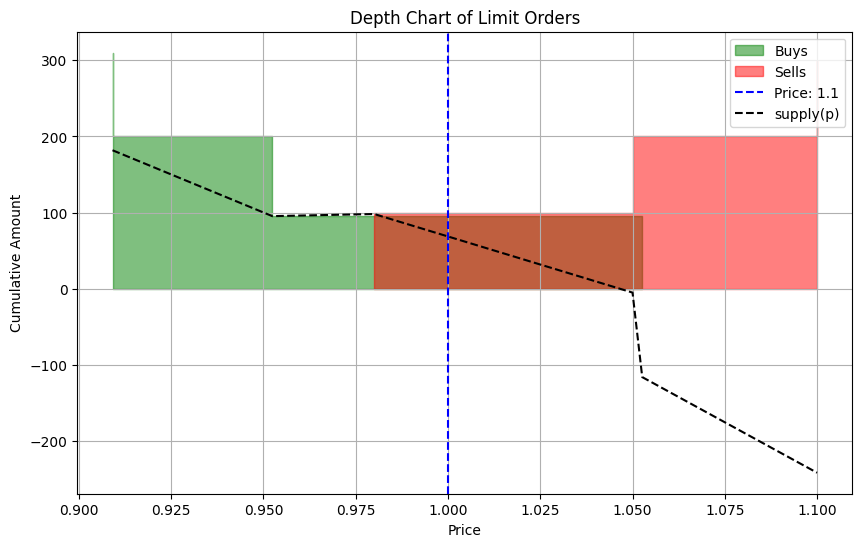

In [4]:
plot_depth_chart(limit_orders, price_vector)

In [5]:
def plot_amm(poolA, poolB, rel_price):
    # Generate points for the constant product curve
    # Avoid zero to prevent division by zero
    a_values = np.linspace(0.98 * poolA, 1.07*poolA, 200)
    b_values = poolA * poolB / a_values

    # Trade vector from the supply function at this price
    pool = ConstantProductAMM(poolA, poolB,'A','B')
    trade_vec = pool.supply(dict(A=rel_price,B=1.))
    trade_amtA = trade_vec['A']
    trade_amtB = -pool.trade(trade_amtA)
    #
    end_point_A = poolA + trade_amtA
    end_point_B = poolB + trade_amtB

    # Price tangent line: y = p * x + c
    # To find c, use the point where the trade ends
    c = end_point_B + 1./rel_price * end_point_A
    tangent_line = -1./rel_price * a_values + c

    # Plotting
    plt.figure(2, figsize=(8, 6))
    plt.clf()
    plt.plot(a_values, b_values, label='Constant Product Curve')
    plt.plot([poolA, end_point_A], [poolB, end_point_B], 'ro-',
             label='Trade vector to reach price')
    plt.plot(a_values, tangent_line, 'b--', label=f'Price {rel_price}')
    plt.xlabel('Amount of Token A')
    plt.ylabel('Amount of Token B')
    plt.title('Automated Market Maker (AMM) Behavior')
    plt.legend()
    plt.grid(True)
    plt.draw()

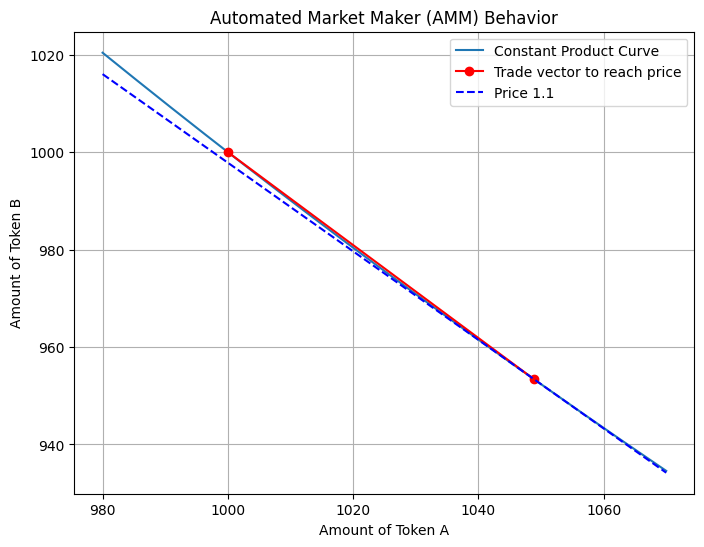

In [6]:
plot_amm(poolA=1000, poolB=1000, rel_price=1.1)

In [7]:
plt.show()